In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import math

In [2]:
# Just get the images we need
style_img = Image.open('images/african_art.jpg')

# Remember, numpy arrays of images is height x width x channels (RGB)
style_array = np.array(style_img)

# Make the channels first 
#style_array = np.rollaxis(style_array, 2, 0)

# Do the same with the content image
content_img = Image.open('images/owl_on_branch.jpg')
content_array = np.array(content_img)

# Define a variable to storing the shape of the images
SHAPE = content_array.shape

# Make channels first for content array
#content_array = np.rollaxis(content_array, 2, 0)

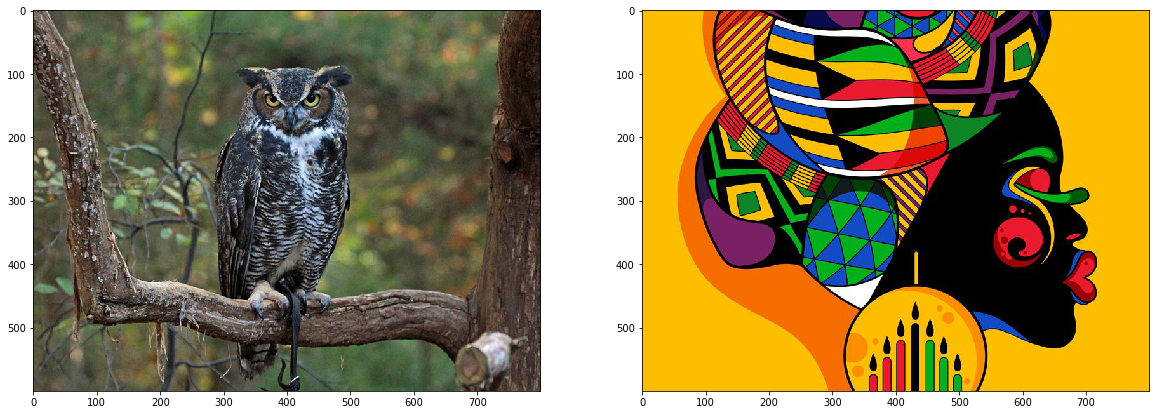

In [3]:
# Show the images
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(content_img)

plt.subplot(1, 2, 2)
plt.imshow(style_img)

In [198]:
# Shows images when the channel is first
def imshow_channels_first(image):
    plt.figure(figsize=(10, 5))
    plt.imshow(np.rollaxis(image[0], 0, 3))
    plt.show()

def imshow_channels_last(image):
    plt.figure(figsize=(10, 5))
    plt.imshow(image[0])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


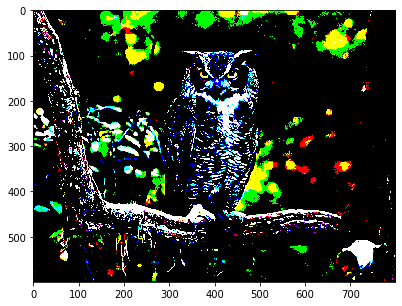

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


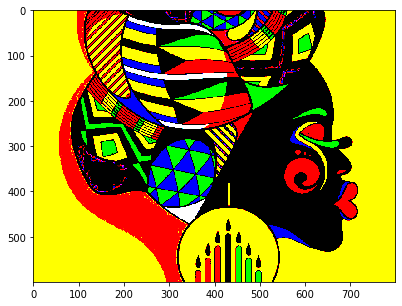

In [199]:
# Normalize the image
def normalization(image):
    vgg_means = [123.68, 116.779, 103.94]
    ret_img = image.astype(dtype=np.float32)
    ret_img[:, :, 0] = ret_img[:, :, 0] - vgg_means[0]
    ret_img[:, :, 1] = ret_img[:, :, 1] - vgg_means[1]
    ret_img[:, :, 2] = ret_img[:, :, 2] - vgg_means[2]
    return ret_img

# Add a 1 to the beginning of the matrix to act as the batch size
norm_content_array = np.expand_dims(normalization(content_array), axis=0)
norm_style_array = np.expand_dims(normalization(style_array), axis=0)

# Show the images
imshow_channels_last(norm_content_array)
imshow_channels_last(norm_style_array)

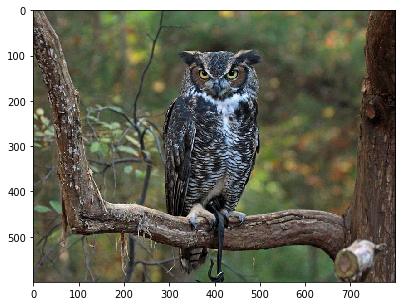

In [185]:
def denormalize(image):
    vgg_means = [123.68, 116.779, 103.94]
    ret_img = image.astype(dtype=np.float32)
    ret_img[:, :, :, 0] = ret_img[:, :, :, 0] + vgg_means[0]
    ret_img[:, :, :, 1] = ret_img[:, :, :, 1] + vgg_means[1]
    ret_img[:, :, :, 2] = ret_img[:, :, :, 2] + vgg_means[2]
    return np.clip(ret_img, 0, 255).astype(dtype=np.uint)

imshow_channels_last(denormalize(norm_content_array))

In [231]:
def save_image(image_array, file_name):
    denorm = denormalize(image_array.numpy())[0]
    denorm = np.uint8(denorm)
    img = Image.fromarray(denorm)
    img.save('generated_images/' + file_name + '.jpg')

In [ ]:
# Test that VGG19 works
vgg_test = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg_test(tf.image.resize(norm_content_array, (224, 224)))
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

In [7]:
# Define the VGG19 model
vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet", pooling = "avg", input_shape = SHAPE)
vgg.trainable = False

In [99]:
# Layers to use when computing the cost
CONTENT_LAYERS = [
    ('block4_conv2', 0.2),
]

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

In [100]:
# Create a model for 
def vgg_model_output(layers):
    layer_outputs = []
    for layer, weight in layers:
        layer_outputs.append(vgg.get_layer(layer).output)
    return tf.keras.Model([vgg.input], layer_outputs)

In [101]:
# Create the variables for the style hidden layers and the content hidden layers
content_activations = vgg_model_output(CONTENT_LAYERS)(norm_content_array)
style_activations = vgg_model_output(STYLE_LAYERS)(norm_style_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


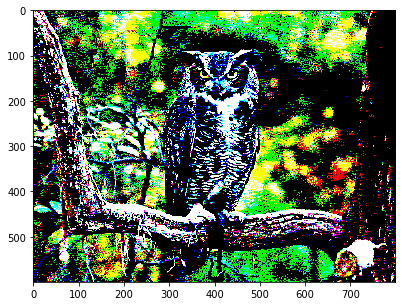

In [102]:
def add_noise_to_img(image):
    mean = 20.0
    std = 10.0
    return image + np.random.normal(mean, std, image.shape)

imshow_channels_last(add_noise_to_img(norm_content_array))

In [200]:
class VGG_Prop(tf.keras.Model):
    def __init__(self):
        super(VGG_Prop, self).__init__()
        # Define the VGG19 model
        self.vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet", pooling = "avg", input_shape = SHAPE)
        self.vgg.trainable = False
        self.style_activations = style_activations
        self.content_activations = content_activations
        
    # Create a model for 
    def vgg_model_output(self, layers):
        layer_outputs = []
        for layer, weight in layers:
            layer_outputs.append(self.vgg.get_layer(layer).output)
        return tf.keras.Model([self.vgg.input], layer_outputs)
    
    def forward_pass_vgg_content(self):
        return self.vgg_model_output(CONTENT_LAYERS)(self.gen_img)
    
    def forward_pass_vgg_style(self):
        return self.vgg_model_output(STYLE_LAYERS)(self.gen_img)
    
    def compute_content_cost(self):
        # Compute the content cost 
        # * Can confirm this works
        m, n_H, n_W, n_C = self.gen_img_content_activations.get_shape().as_list()
        unrolled_content_activations = tf.reshape(self.content_activations, [m, n_W * n_H, n_C])
        unrolled_gen_img_content_activations = tf.reshape(self.gen_img_content_activations, [m, n_W * n_H, n_C])
        
        cost = (1/(4 * n_W * n_H * n_C)) * tf.math.reduce_sum(tf.math.square(tf.subtract(unrolled_content_activations, unrolled_gen_img_content_activations)))
        return cost
        
    def compute_gram(self, matrix):
        return tf.linalg.matmul(matrix, matrix, transpose_b=True)
    
    def style_layer_cost(self, gen_img_layer_activation, style_layer_activation):
        # Retrieve the dimensions from the activations
        m, n_H, n_W, n_C = gen_img_layer_activation.get_shape().as_list()
        
        gen_img_layer_activation = tf.reshape(tf.transpose(gen_img_layer_activation, perm=[3, 1, 2, 0]), shape=[n_C, -1])
        style_layer_activation = tf.reshape(tf.transpose(style_layer_activation, perm=[3, 1, 2, 0]), shape=[n_C, -1])

        gen_gram = self.compute_gram(gen_img_layer_activation)
        style_gram = self.compute_gram(style_layer_activation)
        
        return (1/(4 * n_C**2 * (n_H * n_W)**2)) * tf.math.reduce_sum(tf.math.square(tf.math.subtract(style_gram, gen_gram)))
    
    def style_total_cost(self):
        total_cost = 0.0
        for layer in range(0, len(self.gen_img_style_activations)):
            total_cost = tf.add(total_cost, tf.math.multiply(STYLE_LAYERS[layer][1], self.style_layer_cost(self.gen_img_style_activations[layer], self.style_activations[layer])))
        return total_cost
    
    def total_cost(self, alpha = 10.0, beta = 40.0):
        return tf.math.add(tf.math.multiply(alpha, self.compute_content_cost()), tf.math.multiply(beta, self.style_total_cost()))
        
    def call(self, inputs):
        # Knows this is the only trainable variable
        self.gen_img = inputs
        
        # Create a model to output both the conent and style layers for the gen image
        self.vgg_model = self.vgg_model_output(CONTENT_LAYERS + STYLE_LAYERS)
        
        # Don't want the model to be trainable
        self.vgg_model.trainable = False
        
        # Go through the layers and get the activations for the gen_img
        outputs = self.vgg_model(self.gen_img)
        
        # Seperate the content and style activations
        self.gen_img_content_activations = outputs[:len(CONTENT_LAYERS)][0]
        self.gen_img_style_activations = outputs[len(CONTENT_LAYERS):len(STYLE_LAYERS)]
        
        return self.total_cost()
        


In [201]:
model = VGG_Prop()
gen_img = tf.Variable(add_noise_to_img(norm_content_array), name="gen_img", dtype=tf.float32, trainable=True)

In [202]:
def loss(model):
    return model(gen_img)

def grad(model):
    with tf.GradientTape() as tape:
        loss_value = loss(model)
    return tape.gradient(loss_value, model.variables), loss_value

In [203]:
opt = tf.keras.optimizers.Adam(learning_rate=2.0)
steps = 100
# for i in range(steps):
#     grads, loss_value = grad(model)
#     print(len(model.trainable_variables))
#     opt.apply_gradients(zip(grads, [model.gen_img]))
#     print("Loss at step " + str(i) + " = " + str(loss_value))

def train_step():
    with tf.GradientTape() as tape:
        cost = loss(model)
    grad = tape.gradient(cost, gen_img)
    opt.apply_gradients([(grad, gen_img)])


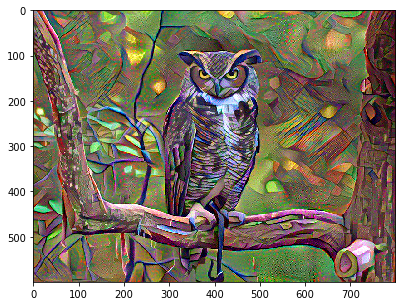

Epoch: 4 Step: 1
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(205517.0, shape=(), dtype=float32)
style cost tf.Tensor(258697890.0, shape=(), dtype=float32)
Epoch: 4 Step: 2
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(205545.23, shape=(), dtype=float32)
style cost tf.Tensor(257974480.0, shape=(), dtype=float32)
Epoch: 4 Step: 3
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(205572.45, shape=(), dtype=float32)
style cost tf.Tensor(257258700.0, shape=(), dtype=float32)
Epoch: 4 Step: 4
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(205598.72, shape=(), dtype=float32)
style cost tf.Tensor(256547420.0, shape=(), dtype=float32)
Epoch: 4 Step: 5
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(205625.12, shape=(), dtype=float32)
style cost tf.Tensor(255840780.0, shape=(), dtype=float32)
Epoch: 4 Step: 6
<class 'tensorflow.python.framework.ops

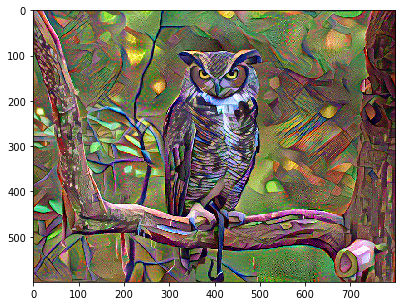

Epoch: 4 Step: 21
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206053.33, shape=(), dtype=float32)
style cost tf.Tensor(245161310.0, shape=(), dtype=float32)
Epoch: 4 Step: 22
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206078.05, shape=(), dtype=float32)
style cost tf.Tensor(244531040.0, shape=(), dtype=float32)
Epoch: 4 Step: 23
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206104.1, shape=(), dtype=float32)
style cost tf.Tensor(243904480.0, shape=(), dtype=float32)
Epoch: 4 Step: 24
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206132.66, shape=(), dtype=float32)
style cost tf.Tensor(243282060.0, shape=(), dtype=float32)
Epoch: 4 Step: 25
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206161.12, shape=(), dtype=float32)
style cost tf.Tensor(242663150.0, shape=(), dtype=float32)
Epoch: 4 Step: 26
<class 'tensorflow.python.framewo

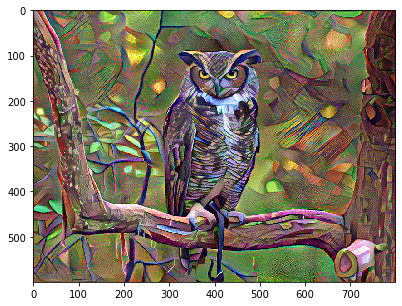

Epoch: 4 Step: 41
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206558.28, shape=(), dtype=float32)
style cost tf.Tensor(233233730.0, shape=(), dtype=float32)
Epoch: 4 Step: 42
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206584.72, shape=(), dtype=float32)
style cost tf.Tensor(232671070.0, shape=(), dtype=float32)
Epoch: 4 Step: 43
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206610.34, shape=(), dtype=float32)
style cost tf.Tensor(232111780.0, shape=(), dtype=float32)
Epoch: 4 Step: 44
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206634.66, shape=(), dtype=float32)
style cost tf.Tensor(231554800.0, shape=(), dtype=float32)
Epoch: 4 Step: 45
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(206657.61, shape=(), dtype=float32)
style cost tf.Tensor(231001390.0, shape=(), dtype=float32)
Epoch: 4 Step: 46
<class 'tensorflow.python.framew

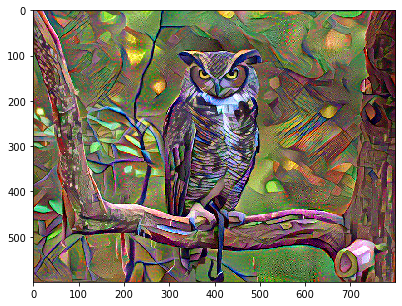

Epoch: 4 Step: 61
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207047.69, shape=(), dtype=float32)
style cost tf.Tensor(222547890.0, shape=(), dtype=float32)
Epoch: 4 Step: 62
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207073.95, shape=(), dtype=float32)
style cost tf.Tensor(222042460.0, shape=(), dtype=float32)
Epoch: 4 Step: 63
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207098.62, shape=(), dtype=float32)
style cost tf.Tensor(221541780.0, shape=(), dtype=float32)
Epoch: 4 Step: 64
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207120.36, shape=(), dtype=float32)
style cost tf.Tensor(221042200.0, shape=(), dtype=float32)
Epoch: 4 Step: 65
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207140.98, shape=(), dtype=float32)
style cost tf.Tensor(220545140.0, shape=(), dtype=float32)
Epoch: 4 Step: 66
<class 'tensorflow.python.framew

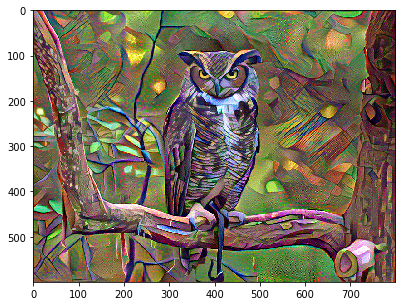

Epoch: 4 Step: 81
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207518.02, shape=(), dtype=float32)
style cost tf.Tensor(212919620.0, shape=(), dtype=float32)
Epoch: 4 Step: 82
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207541.95, shape=(), dtype=float32)
style cost tf.Tensor(212462980.0, shape=(), dtype=float32)
Epoch: 4 Step: 83
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207563.03, shape=(), dtype=float32)
style cost tf.Tensor(212007470.0, shape=(), dtype=float32)
Epoch: 4 Step: 84
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207583.89, shape=(), dtype=float32)
style cost tf.Tensor(211554610.0, shape=(), dtype=float32)
Epoch: 4 Step: 85
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207607.5, shape=(), dtype=float32)
style cost tf.Tensor(211102940.0, shape=(), dtype=float32)
Epoch: 4 Step: 86
<class 'tensorflow.python.framewo

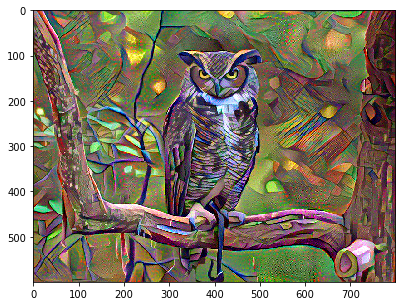

Epoch: 5 Step: 1
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207960.64, shape=(), dtype=float32)
style cost tf.Tensor(204175970.0, shape=(), dtype=float32)
Epoch: 5 Step: 2
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(207983.77, shape=(), dtype=float32)
style cost tf.Tensor(203760200.0, shape=(), dtype=float32)
Epoch: 5 Step: 3
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208006.8, shape=(), dtype=float32)
style cost tf.Tensor(203346940.0, shape=(), dtype=float32)
Epoch: 5 Step: 4
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208028.83, shape=(), dtype=float32)
style cost tf.Tensor(202936400.0, shape=(), dtype=float32)
Epoch: 5 Step: 5
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208050.92, shape=(), dtype=float32)
style cost tf.Tensor(202526910.0, shape=(), dtype=float32)
Epoch: 5 Step: 6
<class 'tensorflow.python.framework.ops

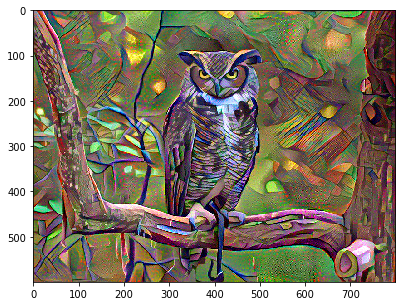

Epoch: 5 Step: 21
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208403.83, shape=(), dtype=float32)
style cost tf.Tensor(196220160.0, shape=(), dtype=float32)
Epoch: 5 Step: 22
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208427.23, shape=(), dtype=float32)
style cost tf.Tensor(195839260.0, shape=(), dtype=float32)
Epoch: 5 Step: 23
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208448.86, shape=(), dtype=float32)
style cost tf.Tensor(195459870.0, shape=(), dtype=float32)
Epoch: 5 Step: 24
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208469.62, shape=(), dtype=float32)
style cost tf.Tensor(195083340.0, shape=(), dtype=float32)
Epoch: 5 Step: 25
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208492.66, shape=(), dtype=float32)
style cost tf.Tensor(194707680.0, shape=(), dtype=float32)
Epoch: 5 Step: 26
<class 'tensorflow.python.framew

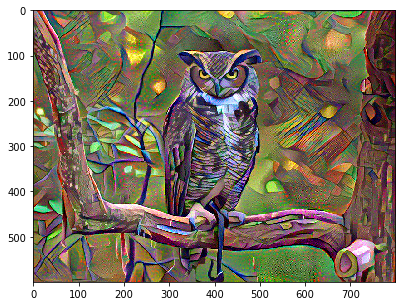

Epoch: 5 Step: 41
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208820.92, shape=(), dtype=float32)
style cost tf.Tensor(188902690.0, shape=(), dtype=float32)
Epoch: 5 Step: 42
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208840.98, shape=(), dtype=float32)
style cost tf.Tensor(188552540.0, shape=(), dtype=float32)
Epoch: 5 Step: 43
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208862.56, shape=(), dtype=float32)
style cost tf.Tensor(188204900.0, shape=(), dtype=float32)
Epoch: 5 Step: 44
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208883.75, shape=(), dtype=float32)
style cost tf.Tensor(187857600.0, shape=(), dtype=float32)
Epoch: 5 Step: 45
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(208902.64, shape=(), dtype=float32)
style cost tf.Tensor(187511970.0, shape=(), dtype=float32)
Epoch: 5 Step: 46
<class 'tensorflow.python.framew

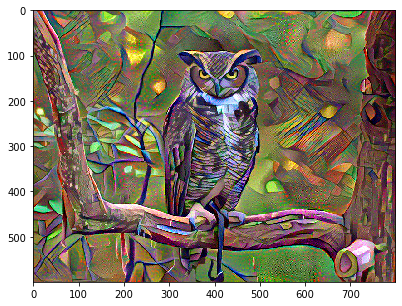

Epoch: 5 Step: 61
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209224.86, shape=(), dtype=float32)
style cost tf.Tensor(182157340.0, shape=(), dtype=float32)
Epoch: 5 Step: 62
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209243.89, shape=(), dtype=float32)
style cost tf.Tensor(181833570.0, shape=(), dtype=float32)
Epoch: 5 Step: 63
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209264.48, shape=(), dtype=float32)
style cost tf.Tensor(181511490.0, shape=(), dtype=float32)
Epoch: 5 Step: 64
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209284.27, shape=(), dtype=float32)
style cost tf.Tensor(181189950.0, shape=(), dtype=float32)
Epoch: 5 Step: 65
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209299.23, shape=(), dtype=float32)
style cost tf.Tensor(180869920.0, shape=(), dtype=float32)
Epoch: 5 Step: 66
<class 'tensorflow.python.framew

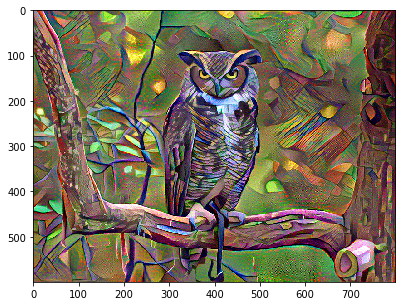

Epoch: 5 Step: 81
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209602.53, shape=(), dtype=float32)
style cost tf.Tensor(175892000.0, shape=(), dtype=float32)
Epoch: 5 Step: 82
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209621.38, shape=(), dtype=float32)
style cost tf.Tensor(175588530.0, shape=(), dtype=float32)
Epoch: 5 Step: 83
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209641.47, shape=(), dtype=float32)
style cost tf.Tensor(175287300.0, shape=(), dtype=float32)
Epoch: 5 Step: 84
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209661.14, shape=(), dtype=float32)
style cost tf.Tensor(174986460.0, shape=(), dtype=float32)
Epoch: 5 Step: 85
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209680.19, shape=(), dtype=float32)
style cost tf.Tensor(174687200.0, shape=(), dtype=float32)
Epoch: 5 Step: 86
<class 'tensorflow.python.framew

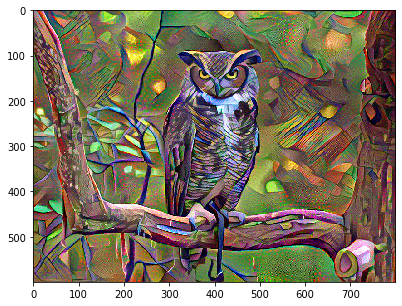

Epoch: 6 Step: 1
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209975.83, shape=(), dtype=float32)
style cost tf.Tensor(170034500.0, shape=(), dtype=float32)
Epoch: 6 Step: 2
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(209992.05, shape=(), dtype=float32)
style cost tf.Tensor(169752620.0, shape=(), dtype=float32)
Epoch: 6 Step: 3
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210008.75, shape=(), dtype=float32)
style cost tf.Tensor(169471900.0, shape=(), dtype=float32)
Epoch: 6 Step: 4
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210029.5, shape=(), dtype=float32)
style cost tf.Tensor(169189860.0, shape=(), dtype=float32)
Epoch: 6 Step: 5
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210047.69, shape=(), dtype=float32)
style cost tf.Tensor(168910580.0, shape=(), dtype=float32)
Epoch: 6 Step: 6
<class 'tensorflow.python.framework.ops

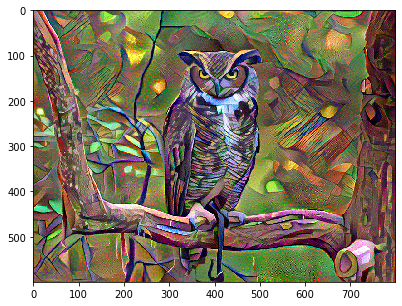

Epoch: 6 Step: 21
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210321.28, shape=(), dtype=float32)
style cost tf.Tensor(164545120.0, shape=(), dtype=float32)
Epoch: 6 Step: 22
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210338.1, shape=(), dtype=float32)
style cost tf.Tensor(164281380.0, shape=(), dtype=float32)
Epoch: 6 Step: 23
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210354.17, shape=(), dtype=float32)
style cost tf.Tensor(164017620.0, shape=(), dtype=float32)
Epoch: 6 Step: 24
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210371.11, shape=(), dtype=float32)
style cost tf.Tensor(163756430.0, shape=(), dtype=float32)
Epoch: 6 Step: 25
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210392.06, shape=(), dtype=float32)
style cost tf.Tensor(163494220.0, shape=(), dtype=float32)
Epoch: 6 Step: 26
<class 'tensorflow.python.framewo

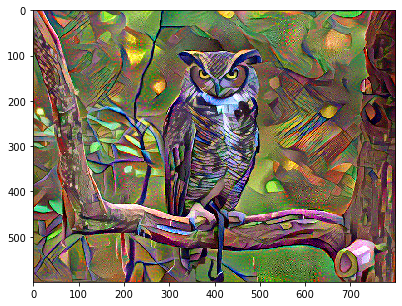

Epoch: 6 Step: 41
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210677.55, shape=(), dtype=float32)
style cost tf.Tensor(159446600.0, shape=(), dtype=float32)
Epoch: 6 Step: 42
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210693.94, shape=(), dtype=float32)
style cost tf.Tensor(159202270.0, shape=(), dtype=float32)
Epoch: 6 Step: 43
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210714.36, shape=(), dtype=float32)
style cost tf.Tensor(158957580.0, shape=(), dtype=float32)
Epoch: 6 Step: 44
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210733.64, shape=(), dtype=float32)
style cost tf.Tensor(158714800.0, shape=(), dtype=float32)
Epoch: 6 Step: 45
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(210750.25, shape=(), dtype=float32)
style cost tf.Tensor(158471460.0, shape=(), dtype=float32)
Epoch: 6 Step: 46
<class 'tensorflow.python.framew

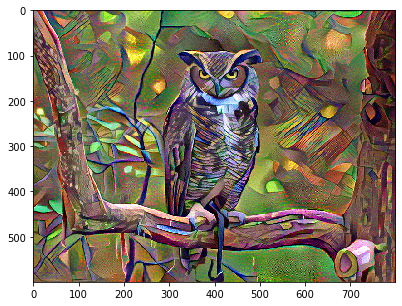

Epoch: 6 Step: 61
<class 'tensorflow.python.framework.ops.EagerTensor'>
content cost tf.Tensor(211021.55, shape=(), dtype=float32)
style cost tf.Tensor(154700200.0, shape=(), dtype=float32)


KeyboardInterrupt: 

In [234]:
epochs = 10
steps_per_epoch = 100
for epoch in range(3, epochs):
    for step in range(steps_per_epoch):
        if (step % 20 == 0):
            imshow_channels_last(denormalize(gen_img.numpy()))
            save_image(gen_img, 'owl_african_2_epoch_' + str(epoch + 1) + '_step_' + str(step + 1))
            
        print("Epoch: " + str(epoch + 1), "Step: " + str(step + 1))
        train_step()

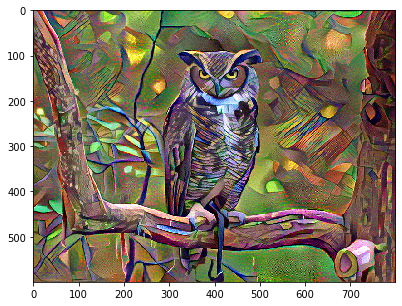

In [235]:
imshow_channels_last(denormalize(gen_img.numpy()))